In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from libs.utils_pollution import *
from libs.utils_meteorological import *
from libs.utils_data import *
from libs.utils_spatial import *

# Préparation des données

In [23]:
# Export all useful constants
borough_geojson_file = 'https://data.montreal.ca/dataset/b628f1da-9dc3-4bb1-9875-1470f891afb1/resource/92cb062a-11be-4222-9ea5-867e7e64c5ff/download/limites-terrestres.geojson'
borough_geojson_file = './data/limites-terrestres.geojson'
# csv_stations_references = 'https://data.montreal.ca/dataset/ae01f7f3-4d69-404a-9be1-74abfdc96571/resource/29db5545-89a4-4e4a-9e95-05aa6dc2fd80/download/liste-des-stations-rsqa.csv'
csv_stations_references = './data/liste-des-stations-rsqa.csv'
# csv_all_pollutants = 'https://data.montreal.ca/dataset/a2eea289-f9b1-4e51-a6fc-3299aa8f2ba7/resource/811e76d0-90cb-4703-bd6f-bd0faff81f4a/download/rsqa-multi-polluants2020.csv'
csv_all_pollutants = './data/rsqa-multi-polluants2020.csv'
meteorological_stations_ids = [51157, 49608, 30165, 48374]
csv_meteo_api = 'https://climat.meteo.gc.ca/climate_data/bulk_data_f.html?format=csv&stationID={STATIONID}&Year={YEAR}&Month={MONTH}&Day={DAY}&time=UTC&timeframe=1&submit=T%C3%A9l%C3%A9charger%20des%20donn%C3%A9es'

## Visualisation des stations de pollution

In [24]:
stations_references = pd.read_csv(csv_stations_references)

<Figure size 1440x1440 with 0 Axes>

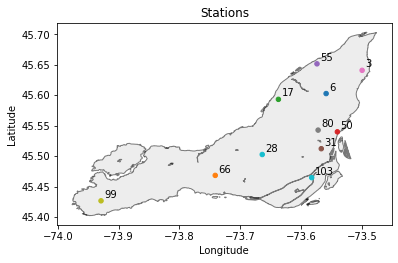

In [25]:
visualise_stations(stations_references[stations_references.statut == 'ouvert'], borough_geojson_file)

## Importation des données de pollution

In [26]:
pollution_data = pd.read_csv(csv_all_pollutants)
pollution_data.head()

,numero_station,date_heure,co,no,no2,pm2_5,pst,pm10,o3,so2,bc1_370nm,bc6_880nm,Benzene,Toluene,Ethylbenzene,M P-Xylene,O-Xylene
0,3,01-01-2020 01:00,N/M,0.121867,8.667018,8.746077,N/M,N/M,15.65643,0,N/M,N/M,5.743625,2.754026,0.355111,6.189929,0.569096
1,3,01-01-2020 02:00,N/M,0.070021,5.937763,5.5934,N/M,N/M,16.69138,0,N/M,N/M,1.40336,1.692388,0.479124,17.34458,0.638791
2,3,01-01-2020 03:00,N/M,0.847384,10.14027,6.916233,N/M,N/M,13.30661,0,N/M,N/M,1.384068,1.533221,0.363582,13.26551,0.476262
3,3,01-01-2020 04:00,N/M,0.343275,6.808739,6.848,N/M,N/M,15.83292,0,N/M,N/M,1.364819,1.456055,0.346235,11.88057,0.420513
4,3,01-01-2020 05:00,N/M,0.085947,4.765573,6.238298,N/M,N/M,17.40574,0,N/M,N/M,0.785679,1.041375,0.248069,9.535387,0.309693


In [27]:
pollution_data = transform_all_pollutants_data(pollution_data)
pollution_data = convert_unknown_values_to_na(pollution_data)
pollution_data = remove_empty_columns(pollution_data)

# # keep only first month
# pollution_data = pollution_data.iloc[:360]

pollution_data.head()

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,no2_station_99,pm2_5_station_99,o3_station_99,so2_station_99,no_station_103,no2_station_103,pm2_5_station_103,pst_station_103,pm10_station_103,o3_station_103
date_heure,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,3.248914,2.837178,20.53666,0.0,0.000000,4.582468,4.249444,5.496387,5.493054,18.90542
2020-01-01 02:00:00,0.070021,5.937763,5.593400,16.69138,0.0,1.403360,1.692388,0.479124,17.344580,0.638791,...,3.324254,3.145111,20.52980,0.0,0.000000,4.323431,5.813416,8.411389,8.065554,18.67736
2020-01-01 03:00:00,0.847384,10.140270,6.916233,13.30661,0.0,1.384068,1.533221,0.363582,13.265510,0.476262,...,3.744425,3.346333,19.87264,0.0,0.076251,4.195025,5.367332,8.120139,7.684998,18.52408
2020-01-01 04:00:00,0.343275,6.808739,6.848000,15.83292,0.0,1.364819,1.456055,0.346235,11.880570,0.420513,...,3.026699,3.581054,21.03147,0.0,0.000000,4.036451,4.810264,6.188667,6.111941,18.76897
2020-01-01 05:00:00,0.085947,4.765573,6.238298,17.40574,0.0,0.785679,1.041375,0.248069,9.535387,0.309693,...,1.800147,3.109388,21.96484,0.0,0.000000,3.402587,4.696846,7.290452,6.689124,19.69922


In [28]:
pollution_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 01:00:00 to 2021-01-01 00:00:00
Data columns (total 64 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   no_station_3            8662 non-null   float64
 1   no2_station_3           8662 non-null   float64
 2   pm2_5_station_3         8716 non-null   float64
 3   o3_station_3            8578 non-null   float64
 4   so2_station_3           8752 non-null   float64
 5   Benzene_station_3       8487 non-null   float64
 6   Toluene_station_3       8487 non-null   float64
 7   Ethylbenzene_station_3  8487 non-null   float64
 8   M P-Xylene_station_3    8487 non-null   float64
 9   O-Xylene_station_3      8487 non-null   float64
 10  no_station_6            8459 non-null   float64
 11  no2_station_6           8459 non-null   float64
 12  pm2_5_station_6         8173 non-null   float64
 13  o3_station_6            8295 non-null   float64
 14  so2_

## Importation des données météorologiques

In [29]:
use_local_file = True

if(use_local_file==True):
    meteorological_data = pd.read_csv('./data/meteorological_data.csv')
    meteorological_data['Date/Heure (UTC)'] = pd.to_datetime(meteorological_data['Date/Heure (UTC)'], format='%Y-%m-%d %H:%M')
    meteorological_data = meteorological_data.set_index('Date/Heure (UTC)')
else:
    datetime_indexes = pollution_data.index.values
    meteorological_data = load_meteorological_data(datetime_indexes, csv_meteo_api, meteorological_stations_ids)

meteorological_data.head()

,Longitude (x),Latitude (y),Nom de la Station,ID climatologique,Année,Mois,Jour,Heure (UTC),Temp (°C),Temp Indicateur,...,Vit. du vent Indicateur,Visibilité (km),Visibilité Indicateur,Pression à la station (kPa),Pression à la station Indicateur,Hmdx,Hmdx Indicateur,Refroid. éolien,Refroid. éolien Indicateur,Temps
Date/Heure (UTC),,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,00:00,"0,5",NaN,...,NaN,"2,4",NaN,"99,44",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 01:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,01:00,"0,6",NaN,...,NaN,"4,0",NaN,"99,41",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 02:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,02:00,"0,5",NaN,...,NaN,"24,1",NaN,"99,38",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 03:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,03:00,"0,5",NaN,...,NaN,"12,9",NaN,"99,38",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 04:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,04:00,"0,3",NaN,...,NaN,"9,7",NaN,"99,35",NaN,NaN,NaN,NaN,NaN,Neige


In [30]:
meteorological_data = remove_empty_columns(meteorological_data)
meteorological_data = remove_unused_columns(meteorological_data)
meteorological_data = convert_columns_to_float_type(meteorological_data)

meteorological_data.head()

,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Hmdx,Refroid. éolien
Date/Heure (UTC),,,,,,,,,
2020-01-01 00:00:00,0.5,-0.3,94.0,9.0,5.0,2.4,99.44,NaN,NaN
2020-01-01 01:00:00,0.6,0.0,96.0,16.0,13.0,4.0,99.41,NaN,NaN
2020-01-01 02:00:00,0.5,-0.3,95.0,24.0,19.0,24.1,99.38,NaN,NaN
2020-01-01 03:00:00,0.5,-1.0,90.0,25.0,19.0,12.9,99.38,NaN,NaN
2020-01-01 04:00:00,0.3,-1.2,90.0,24.0,20.0,9.7,99.35,NaN,NaN


In [31]:
meteorological_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9528 entries, 2020-01-01 00:00:00 to 2021-01-31 23:00:00
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temp (°C)                    9526 non-null   float64
 1   Point de rosée (°C)          9527 non-null   float64
 2   Hum. rel (%)                 9527 non-null   float64
 3   Dir. du vent (10s deg)       9520 non-null   float64
 4   Vit. du vent (km/h)          9527 non-null   float64
 5   Visibilité (km)              9527 non-null   float64
 6   Pression à la station (kPa)  9527 non-null   float64
 7   Hmdx                         1540 non-null   float64
 8   Refroid. éolien              2849 non-null   float64
dtypes: float64(9)
memory usage: 744.4 KB


## Concaténation des données de pollution et météorologiques 

In [32]:
data = pd.concat([pollution_data, meteorological_data], axis=1, join='outer')
data.head(5)

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,o3_station_103,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Hmdx,Refroid. éolien
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5,-0.3,94.0,9.0,5.0,2.4,99.44,NaN,NaN
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,18.90542,0.6,0.0,96.0,16.0,13.0,4.0,99.41,NaN,NaN
2020-01-01 02:00:00,0.070021,5.937763,5.593400,16.69138,0.0,1.403360,1.692388,0.479124,17.344580,0.638791,...,18.67736,0.5,-0.3,95.0,24.0,19.0,24.1,99.38,NaN,NaN
2020-01-01 03:00:00,0.847384,10.140270,6.916233,13.30661,0.0,1.384068,1.533221,0.363582,13.265510,0.476262,...,18.52408,0.5,-1.0,90.0,25.0,19.0,12.9,99.38,NaN,NaN
2020-01-01 04:00:00,0.343275,6.808739,6.848000,15.83292,0.0,1.364819,1.456055,0.346235,11.880570,0.420513,...,18.76897,0.3,-1.2,90.0,24.0,20.0,9.7,99.35,NaN,NaN


## Gestion des valeurs manquantes

>>> Missing value visualization:


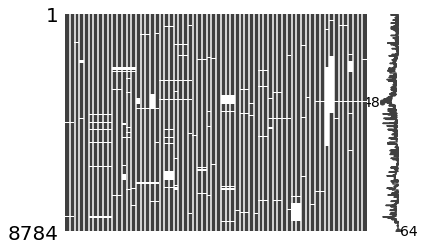

In [33]:
inspect_data(df = pollution_data)

>>> Missing value visualization:


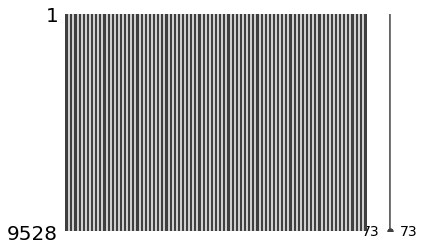

In [34]:
data = data.fillna(method='ffill')
data = data.fillna(method='bfill')
inspect_data(df = data)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9528 entries, 2020-01-01 00:00:00 to 2021-01-31 23:00:00
Freq: H
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   no_station_3                 9528 non-null   float64
 1   no2_station_3                9528 non-null   float64
 2   pm2_5_station_3              9528 non-null   float64
 3   o3_station_3                 9528 non-null   float64
 4   so2_station_3                9528 non-null   float64
 5   Benzene_station_3            9528 non-null   float64
 6   Toluene_station_3            9528 non-null   float64
 7   Ethylbenzene_station_3       9528 non-null   float64
 8   M P-Xylene_station_3         9528 non-null   float64
 9   O-Xylene_station_3           9528 non-null   float64
 10  no_station_6                 9528 non-null   float64
 11  no2_station_6                9528 non-null   float64
 12  pm2_5_station_6              952

In [36]:
#Comme l'algorithme de RFE est chronophage, on retire les feature les plus corrélées entre elles afin de réduire le temps de chargement
correlated_features = set()
correlation_matrix = data.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

data_light = data.drop(correlated_features, axis=1)
data_light.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9528 entries, 2020-01-01 00:00:00 to 2021-01-31 23:00:00
Freq: H
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   no_station_3                 9528 non-null   float64
 1   no2_station_3                9528 non-null   float64
 2   pm2_5_station_3              9528 non-null   float64
 3   o3_station_3                 9528 non-null   float64
 4   so2_station_3                9528 non-null   float64
 5   Benzene_station_3            9528 non-null   float64
 6   Toluene_station_3            9528 non-null   float64
 7   Ethylbenzene_station_3       9528 non-null   float64
 8   M P-Xylene_station_3         9528 non-null   float64
 9   no_station_6                 9528 non-null   float64
 10  so2_station_6                9528 non-null   float64
 11  co_station_17                9528 non-null   float64
 12  no_station_17                952

# Feature Selection

The main goal of this notebook is to explore the various feature selection techniques and compare them in order to retain the best ones. But first, let's define clearly what is the feature selection.


### What is feature selection?

Feature selection is a dimensionnality reduction techniques aiming to choose a small subset of the relevant features from the original features by removing irrelevant, redundant, or noisy features. Feature selection usually can lead to better learning performance, higher learning accuracy, lower computational cost, and better model interpretability.

Feature selection occurs as a data preprocessing step in the ML pipeline. It has been proven to be effective and efficient in preparing high-dimensional data for machine learning and pattern recognition problems.

![Image of Danny Butvinik](https://miro.medium.com/max/888/1*vJdhKDHgLLV7el7Vm4PuEQ.jpeg)


### Which techniques?

Feature selection techniques can be roughly summarized in 3 categories: Filter, wrapper and embedded methods.

*   ***Filter methods***: features are selected based on statistical measures. It is independent of the learning algorithm and requires less computational time. Among existing techniques: chi-2, pearson correlation, missing value ratio..
*   ***Wrapper methods***: in wrapper methods a predictive model is used to evaluate a combination of features and assign model performance scores. The performance of the Wrapper method depends on the classifier. The best subset of features is selected based on the results of the classifier. Wrapper methods are computationally more expensive than filter methods, due to the repeated learning steps and cross-validation. However, these methods are more accurate than the filter method. Some of the examples are Recursive feature elimination, Sequential feature selection algorithms, and Genetic algorithms.
*   ***Embedded methods***: in embedded methods, there are ensemble learning and hybrid learning methods for feature selection. Since it has a collective decision, its performance is better than the other two models. Random forest is one such example. It is computationally less intensive than wrapper methods. However, this method has a drawback specific to a learning model.
In embedded techniques, the feature selection algorithm is integrated as part of the learning algorithm. The most typical embedded technique is the decision tree algorithm. Decision tree algorithms select a feature in each recursive step of the tree growth process and divide the sample set into smaller subset

![Image of Danny Butvinik](https://miro.medium.com/max/1400/1*9h2qPmOJonbCdthfeVkuyg.jpeg)



#### Pour tester les outputs de certaines techniques de feature selection, nous allons définir deux targets différentes représentant les polluants mesurés par les capteurs. Par défaut, nous allons prendre le PM 2.5 et le NO de la station 3.

In [50]:
#On définit nos targets, ici par défaut PM 2.5 et NO de la station 3
target_1 = 'pm2_5_station_3'
target_2 = 'no_station_3'

#On définit le nombre de features à selectionner
n_features = 15

In [116]:
X_1 = data.drop(target_1, axis=1)
y_1 = data[target_1]

X_2 = data.drop(target_2, axis=1)
y_2 = data[target_2]

## **Pearson Correlation (méthode filtrante)**

Statistique qui mesure la corrélation linéaire entre deux variables, qui sont toutes deux continues. Elle varie de -1 à +1, où
+1 correspond à une corrélation linéaire positive, 0 à une absence de corrélation linéaire, et -1 à une corrélation linéaire négative.


In [52]:
#Calcul du coefficient de pearson
target_correlation_1 = data.corr()[[target_1]]
target_correlation_2 = data.corr()[[target_2]]

In [53]:
features_1 = list(abs(target_correlation_1).sort_values(by=target_1, ascending=False)[:n_features].index)
features_2 = list(abs(target_correlation_2).sort_values(by=target_2, ascending=False)[:n_features].index)

Grâce à cette méthode nous pouvons décider de ne garder que les features les plus corrélées avec notre target.

<AxesSubplot:>

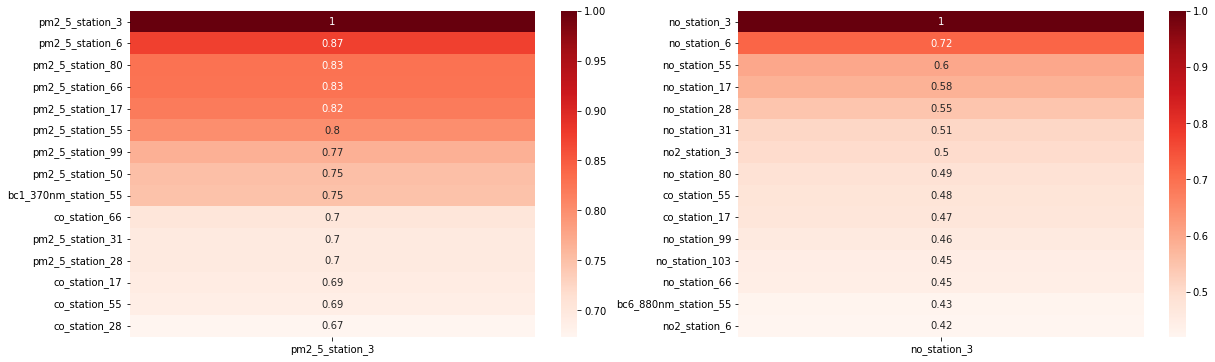

<Figure size 1728x1728 with 0 Axes>

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig = plt.figure(figsize=(24,24))
fig.suptitle('Most correlated features with targets PM2.5 and NO')

#On visualise sur une heatmap les corrélations avec la target

#On ne visualise sur les feature les plus corrélées avec la target
sns.heatmap(target_correlation_1.loc[features_1], annot=True, cmap=plt.cm.Reds, ax=ax1)
sns.heatmap(target_correlation_2.loc[features_2], annot=True, cmap=plt.cm.Reds, ax=ax2)

Parmi les features les plus corrélées avec notre target, il faudrait garder uniquement celles qui ne sont pas énormément corrélées entre elles (sinon nous sommes sur une redondance d'information). Cette étape devrait être réalisée en amont avant toute autre technique de feature selection.

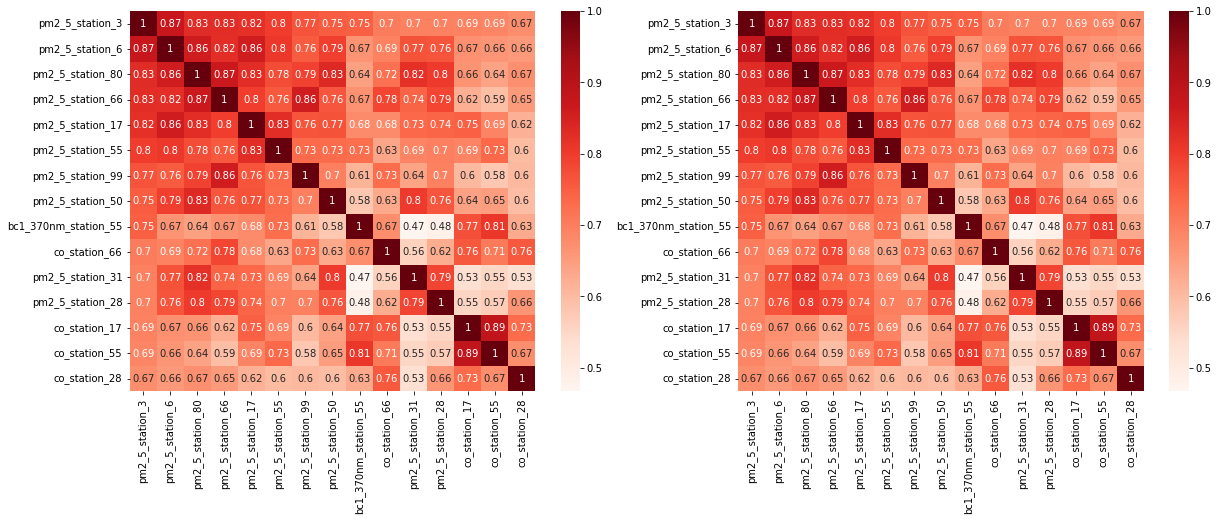

<Figure size 1728x1728 with 0 Axes>

In [56]:
#We look at correlation between chosen features
feature_correlation_1 = data.corr().loc[features_1][features_1]
feature_correlation_2 = data.corr().loc[features_2][features_2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig = plt.figure(figsize=(24,24))
fig.suptitle('Correlation between chosen features')

sns.heatmap(feature_correlation_1, annot=True, cmap=plt.cm.Reds, ax=ax1)
sns.heatmap(feature_correlation_1, annot=True, cmap=plt.cm.Reds, ax=ax2)

plt.show()

## **Recursive Feature Elimination (méthode wrapper)**

RFE recherche un sous-ensemble de features en commençant par toutes les features de l'ensemble de données d'apprentissage et en supprimant des features jusqu'à ce qu'il reste le nombre souhaité.

Pour ce faire, RFE utilise un modèle ML qui est ajusté. Les features sont classées par ordre d'importance. Les features les moins importantes sont éliminées et le modèle est réajusté. Ce processus est répété jusqu'à ce qu'il reste un nombre donné de features.

In [43]:
data.head()

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,o3_station_103,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Hmdx,Refroid. éolien
2020-01-01 00:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,18.90542,0.5,-0.3,94.0,9.0,5.0,2.4,99.44,25.0,-5.0
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,18.90542,0.6,0.0,96.0,16.0,13.0,4.0,99.41,25.0,-5.0
2020-01-01 02:00:00,0.070021,5.937763,5.593400,16.69138,0.0,1.403360,1.692388,0.479124,17.344580,0.638791,...,18.67736,0.5,-0.3,95.0,24.0,19.0,24.1,99.38,25.0,-5.0
2020-01-01 03:00:00,0.847384,10.140270,6.916233,13.30661,0.0,1.384068,1.533221,0.363582,13.265510,0.476262,...,18.52408,0.5,-1.0,90.0,25.0,19.0,12.9,99.38,25.0,-5.0
2020-01-01 04:00:00,0.343275,6.808739,6.848000,15.83292,0.0,1.364819,1.456055,0.346235,11.880570,0.420513,...,18.76897,0.3,-1.2,90.0,24.0,20.0,9.7,99.35,25.0,-5.0


Feature selection techniques can be time-consuming. As we have a lot of features (more than 70), we should try removing as much as possible irrelevant features. We can use the Pearson Correlation to remove highly correlated features as they convey the same information, as well as poorly correlated feature with our target.

In [127]:
#We first remove target poorly correlated features and then highly correlated features

#We remove target poorly correlated features
not_corr_1 = abs(target_correlation_1).sort_values(by=target_1)
not_correlated_features_1 = list(not_corr_1[not_corr_1[target_1] < 0.1].index)
not_corr_2 = abs(target_correlation_2).sort_values(by=target_2)
not_correlated_features_2 = list(not_corr_2[not_corr_2[target_2] < 0.1].index)

correlated_features = set()
correlation_matrix = data.corr()

#We remove highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

drop_features_1, drop_features_2 = correlated_features, correlated_features

drop_features_1.update(not_correlated_features_1)
drop_features_2.update(not_correlated_features_2)

X_1 = X_1.drop(drop_features_1, axis=1)
X_2 = X_2.drop(drop_features_2, axis=1)

Ici on utilise le modèle des Random Forests, un algorithme de classification composé de nombreux arbres de décision, comme modèle à la base de notre technique de feature selection.

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

rfc = RandomForestRegressor(random_state=101)
rfe_1 = RFECV(estimator=rfc, step=1, verbose=True)
rfe_1.fit(X_1, y_1)

rfe_2 = RFECV(estimator=rfc, step=1, verbose=False)
rfe_2.fit(X_2, y_2)

RFE(estimator=RandomForestRegressor(random_state=101), verbose=False)

RFE nous indiquer quel est le nombre de features optimal dans le modèle utilisé pour atteindre le meilleur score de regression/classification (regression dans notre cas)

In [111]:
print('Optimal number of features for target_1: {}'.format(rfe_1.n_features_))
print('Optimal number of features for target_2: {}'.format(rfe_2.n_features_))

Optimal number of features for target_1: 21
Optimal number of features for target_2: 21


In [112]:
optimal_features_ranking_1 = rfe_1.ranking_
ind_1 = np.where(optimal_features_ranking_1 == 1)[0]
print("Optimal features: ", list(X_1.iloc[:,ind_1].columns))

optimal_features_ranking_2 = rfe_2.ranking_
ind_2 = np.where(optimal_features_ranking_2 == 1)[0]
print("Optimal features: ", list(X_2.iloc[:,ind_2].columns))

Optimal features:  ['no_station_3', 'no2_station_3', 'o3_station_3', 'so2_station_3', 'Benzene_station_3', 'Ethylbenzene_station_3', 'M P-Xylene_station_3', 'no_station_6', 'co_station_17', 'co_station_28', 'pm2_5_station_28', 'no_station_31', 'pm2_5_station_31', 'pst_station_50', 'no_station_55', 'co_station_66', 'o3_station_99', 'pm2_5_station_103', 'Temp (°C)', 'Hum. rel (%)', 'Pression à la station (kPa)']
Optimal features:  ['no2_station_3', 'pm2_5_station_3', 'o3_station_3', 'so2_station_3', 'Benzene_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3', 'M P-Xylene_station_3', 'no_station_6', 'co_station_17', 'no_station_17', 'no_station_28', 'pst_station_28', 'no_station_31', 'no2_station_31', 'pst_station_50', 'no_station_55', 'no_station_80', 'no2_station_99', 'no_station_103', 'no2_station_103']


Text(0, 0.5, '% Score')

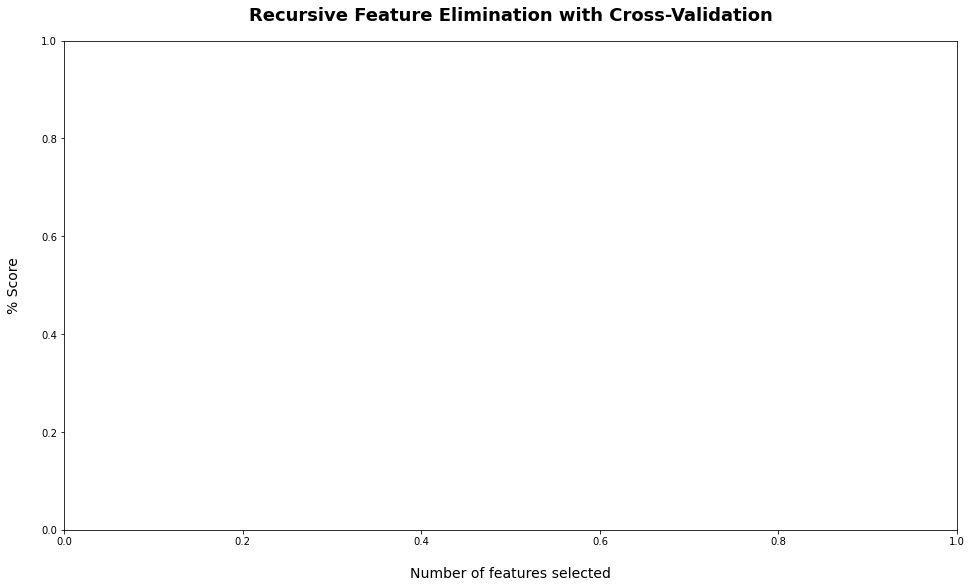

In [128]:
#Affichage du score en fonction du nombre de features prises en compte par le modèle
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Score', fontsize=14, labelpad=20)
#plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

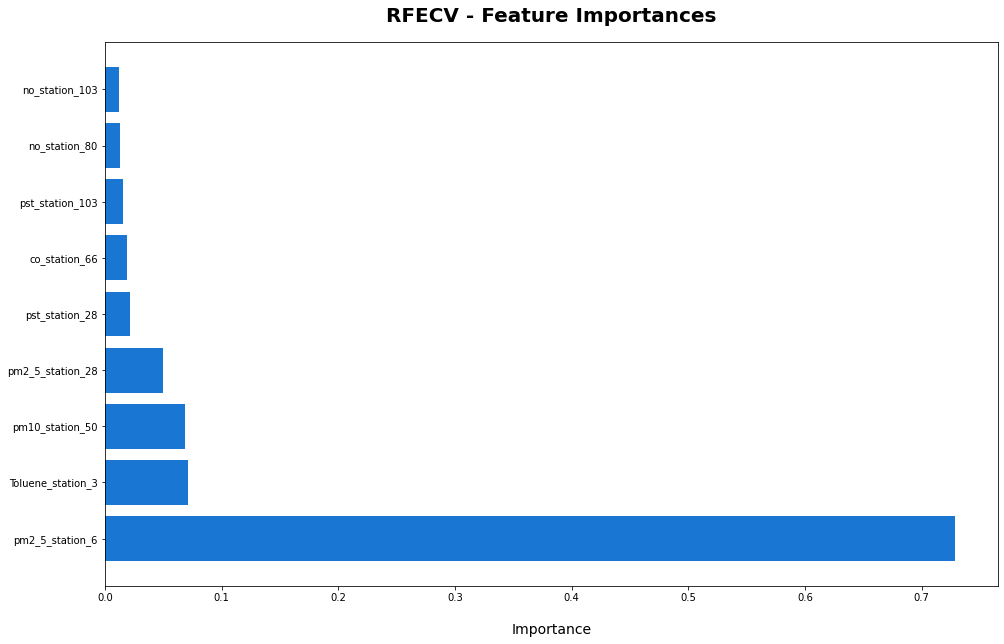

In [36]:
#Affichage de l'importance de toutes les features pour prédire la target
dset = pd.DataFrame()
dset['attr'] = X.iloc[:,ind].columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## **Boruta (méthode wrapper)**

Contrairement à la technique RFE où les features étaient en compétition les unes avec les autres pour une place dans le sous-ensemble final, dans Boruta les features sont en compétition avec une version randomisée d'elles-mêmes (shadow features). Une feature n'est sélectionnée que si elle est plus performante que la feature aléatoire la plus performante.

![Image of Manish Pathak](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1520429681/boruta_algo_ft1i8z.png)

La procédure est répétée N fois (nombre d'essais) et l'étape finale consiste à comparer le nombre de fois où une feature a été meilleure que ses shadow features en utilisant une distribution binomiale. En ce qui concerne les features de la zone bleue, l'algorithme de Boruta est indécis,
tandis que les features dans la zone verte et rouge doivent être sélectionnées et éliminées, respectivement.

![Image of Samuele Mazzanti](https://miro.medium.com/max/1400/1*yqAUlMtPUiFyr8gYLFagTA.png)



In [37]:
from boruta import BorutaPy

#Le modèle ici est le même que pour le RFE, i.e un modèle Random Forest
estimator = RandomForestRegressor()

boruta_1 = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100, verbose=True)
boruta_1.fit(np.array(X_1), np.array(y_1))

boruta_2 = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100, verbose=True)
boruta_2.fit(np.array(X_2), np.array(y_2))

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=RandomForestRegressor(n_estimators=74,
                                         random_state=RandomState(MT19937) at 0x10F8D2D40),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x10F8D2D40,
         verbose=True)

On peut afficher les features considérées comme importantes, non-importantes et celles non catégorisées.

In [38]:
#For target_1

#Features importantes
important = list(X_1.columns[boruta_1.support_])
print(f"Features confirmed as important: {important}")

# Features non catégorisées
tentative = list(X_1.columns[boruta_1.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

# Features non importantes
unimportant = list(X_1.columns[~(boruta_1.support_ | boruta_1.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['no2_station_3', 'Benzene_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3', 'pm2_5_station_6', 'co_station_17', 'co_station_28', 'no_station_28', 'pm2_5_station_28', 'pst_station_28', 'no_station_31', 'so2_station_31', 'pst_station_50', 'pm10_station_50', 'co_station_66', 'no_station_66', 'no_station_80', 'no_station_103', 'no2_station_103', 'pst_station_103', 'pm10_station_103', 'o3_station_103', 'Pression à la station (kPa)']
Unconfirmed features (tentative): ['no_station_99', 'Vit. du vent (km/h)']
Features confirmed as unimportant: ['no_station_3', 'so2_station_3', 'no_station_6', 'so2_station_6', 'no_station_17', 'so2_station_80', 'so2_station_99', 'Temp (°C)', 'Hum. rel (%)', 'Dir. du vent (10s deg)', 'Visibilité (km)']


In [ ]:
#For target_2

#Features importantes
important = list(X_2.columns[boruta_2.support_])
print(f"Features confirmed as important: {important}")

# Features non catégorisées
tentative = list(X_2.columns[boruta_2.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

# Features non importantes
unimportant = list(X_2.columns[~(boruta_2.support_ | boruta_2.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

## **Boruta SHAP**

Boruta is a robust method for feature selection, but it strongly relies on the calculation of the feature importances, which might be biased or not good enough for the data.
This is where SHAP joins the team. By using SHAP Values as the feature selection method in Boruta, we get the Boruta SHAP Feature Selection Algorithm. With this approach we can get the strong addictive feature explanations existent in SHAP method while having the robustness of Boruta algorithm to ensure only significant variables remain on the set.

#### **SHAP (SHapley Additive exPlanations)** 
SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.
Linear models, for example, can use their coefficients as a metric for the overall importance of each feature, but they are scaled with the scale of the variable itself, which might lead to distortions and misinterpretations. Also, the coefficient cannot account for the local importance of the feature, and how it changes with lower or higher values. The same can be said for feature importances of tree-based models, and this is why SHAP is useful for interpretability of models.

In [130]:
from BorutaShap import BorutaShap

# Creates a BorutaShap selector for regression
boruta_shap_1 = BorutaShap(importance_measure = 'shap', classification = False)
boruta_shap_2 = BorutaShap(importance_measure = 'shap', classification = False)

In [131]:
# Fits the selector
boruta_shap_1.fit(X_1, y_1, n_trials = 100, sample = True, verbose = True)
boruta_shap_2.fit(X_2, y_2, n_trials = 100, sample = True, verbose = True)

# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

  2%|▏         | 2/100 [12:02<9:46:45, 359.24s/it] 